In [1]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
df = pd.read_csv('../data/descripciones.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})

df = df.drop(columns=["direccion","descripcion","titulo"])

In [3]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [4]:
def imputar(df,cols):
    imp = SimpleImputer()
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [5]:
#Columnas numericas

data_cols = df._get_numeric_data().columns

#Completo los nulos
df1 = imputar(df,data_cols)

baseline_data = df1[data_cols]

#Normalizo
min_max_scaler = MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(baseline_data)

baseline_data = pd.DataFrame(x_scaled,columns=data_cols)

In [6]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']

encoder = ce.BinaryEncoder()

encoded = encoder.fit_transform(df1[cat_features])

data = baseline_data.join(encoded)

data.dropna(inplace=True)

x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [8]:
xgb_model = xgb.XGBRegressor(n_estimators=400,max_depth=10,n_jobs=-1,objective="reg:squarederror")
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [9]:
predecir(xgb_model,x_train,y_train,x_test,y_test)

Entrenamiento: 95.5510%
Testeo: 81.6432%.


0.816432094532479

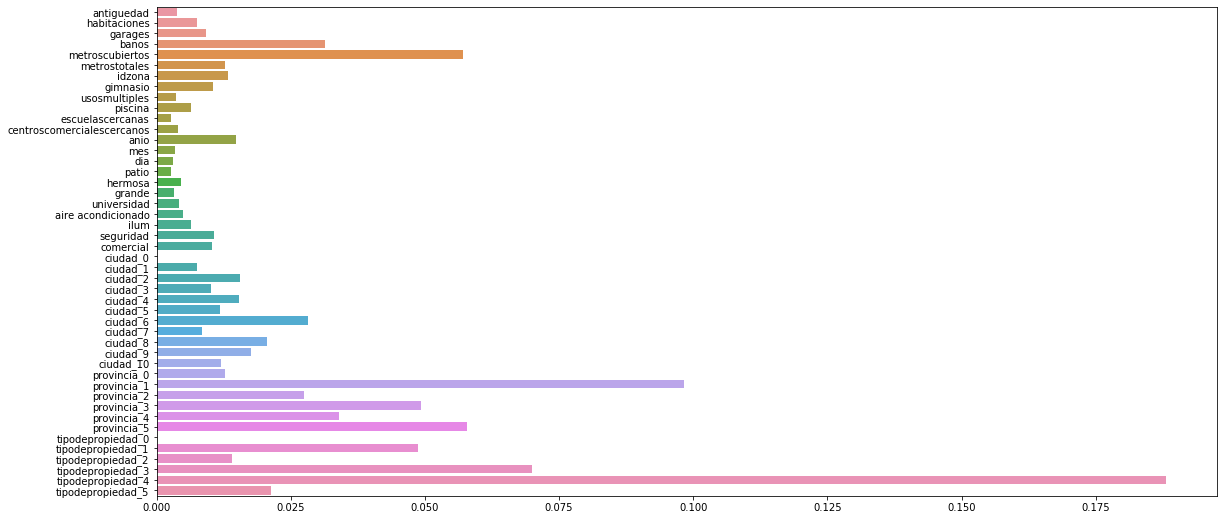

In [11]:
importancia = xgb_model.feature_importances_
plt.rcParams["figure.figsize"] =[19,9]
ax=sns.barplot(y=x.columns, x=xgb_model.feature_importances_)
